In [1]:
import torch
import sys
import string
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets
from PIL import Image
from datetime import datetime, time
import pickle

from torch.utils.data import Dataset, DataLoader, random_split

import os
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple

from typing import Tuple, List, Type, Dict, Any

In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
torch.cuda.is_available()

False

In [4]:
train_loss_hist = []
test_loss_hist = []

In [5]:
with open('./train/index.pkl', 'rb') as f:
    data_index = pickle.load(f)

In [7]:
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


# TODO: specify the return type
def accimage_loader(path: str) -> Any:
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path: str) -> Any:
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [7]:
print(data_index[0])

print(data_index[1])

print(data_index[2])

print(data_index[3])


{'jpg_filename': 'img-2019-12-11T10-02-37devID2.jpg', 'lon': -10.783049166666666, 'lat': 41.343314666666664, 'mask_fname': 'AMK79/masks/mask-id2.png', 'mission': 'AMK79', 'devID': 2, 'observations_dt': datetime.datetime(2019, 12, 11, 10, 0), 'observed_TCC': 4}
{'jpg_filename': 'img-2019-12-11T09-56-17devID2.jpg', 'lon': -10.775719833333333, 'lat': 41.35916666666667, 'mask_fname': 'AMK79/masks/mask-id2.png', 'mission': 'AMK79', 'devID': 2, 'observations_dt': datetime.datetime(2019, 12, 11, 10, 0), 'observed_TCC': 4}
{'jpg_filename': 'img-2019-12-11T10-04-17devID1.jpg', 'lon': -10.7849575, 'lat': 41.33913483333333, 'mask_fname': 'AMK79/masks/mask-id1.png', 'mission': 'AMK79', 'devID': 1, 'observations_dt': datetime.datetime(2019, 12, 11, 10, 0), 'observed_TCC': 4}
{'jpg_filename': 'img-2019-12-11T14-00-00devID2.jpg', 'lon': -11.037791666666667, 'lat': 40.761530666666665, 'mask_fname': 'AMK79/masks/mask-id2.png', 'mission': 'AMK79', 'devID': 2, 'observations_dt': datetime.datetime(2019, 1

In [8]:
class MyImageFolder(Dataset):
    def __init__(self, 
            root: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None):

        Samples = []
        for i in range(len(data_index)):
            Path = root + data_index[i]['mission'] + '/snapshots/snapshots' + data_index[i]['jpg_filename'][3:14] + '/' + data_index[i]['jpg_filename']
            Target = data_index[i]['observed_TCC']
            res = Path, Target
            Samples.append(res)

        self.samples = Samples
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        Sample = default_loader(path)
        mask = default_loader('./train/' + data_index[index]['mask_fname'])
        mask = mask.resize((512,512))
        
        if self.transform is not None:
            Sample = self.transform(Sample)
            mask = self.transform(mask)

        if self.target_transform is not None:
            target = self.target_transform(target)

        Sample = mask * Sample

        return Sample, target
        

In [9]:
class ConvNet(torch.nn.Module):
    
    def __init__(self, 
                 input_resolution: Tuple[int, int] = (512, 512),
                 input_channels: int = 1, 
                 filters_shape: List[List[int]] = [[16,3,3],
                                                   [64,3,3],
                                                   [128,3,3]],
                 activation: Type[torch.nn.Module] = torch.nn.ReLU,
                 num_classes: int = 10):

        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, 3, 1, padding=(1,1))
        self.conv2 = torch.nn.Conv2d(64, 64, 3, 1, padding=(1,1))
        self.conv3 = torch.nn.Conv2d(64, 128, 3, 1, padding=(1,1))
        self.conv4 = torch.nn.Conv2d(128, 128, 3, 1, padding=(1,1))
        self.conv5 = torch.nn.Conv2d(128, 256, 3, 1, padding=(1,1))
        self.conv6 = torch.nn.Conv2d(256, 256, 3, 1, padding=(1,1))
        self.conv7 = torch.nn.Conv2d(256, 512, 3, 1, padding=(1,1))
        self.conv8 = torch.nn.Conv2d(512, 512, 3, 1, padding=(1,1))
        self.conv10 = torch.nn.Conv2d(3, 64, 5, 1, padding=(2,2))
        self.conv11 = torch.nn.Conv2d(64, 128, 5, 1, padding=(2,2))
        self.conv12 = torch.nn.Conv2d(128, 256, 5, 1, padding=(2,2))
        #self.maxpooling = torch.nn.MaxPool2d(2)
        self.maxpooling = torch.nn.MaxPool2d(2)
        
        self.avg = torch.nn.AdaptiveAvgPool2d(7)
        self.fc1 = torch.nn.Linear(25088, 4096)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(4096, 1000)
        self.fc3 = torch.nn.Linear(1000, 9)
        self.fc4 = torch.nn.Linear(12544,1000)

    
    def forward(self, x):

        x = F.relu(self.conv10(x))
        x = self.maxpooling(x)
        x = F.relu(self.conv11(x))
        x = self.maxpooling(x) 
        x = F.relu(self.conv12(x))
        x = self.maxpooling(x)
        x = self.avg(x)
        x = torch.flatten(x,1)
         #x = self.maxpooling(x)
         #x = self.maxpooling(x)



        
        x = F.relu(self.fc4(x))
        x = self.fc3(x)
        x = F.log_softmax(x)


#         x = F.relu(self.conv1(x))
#         x = F.relu(self.conv2(x))
#         x = self.maxpooling(x)

#         x = F.relu(self.conv3(x))
#         x = F.relu(self.conv4(x))
#         x = self.maxpooling(x)  

#         x = F.relu(self.conv5(x))
#         x = F.relu(self.conv6(x))
#         x = F.relu(self.conv6(x))
#         x = self.maxpooling(x)

#         x = F.relu(self.conv7(x))
#         x = F.relu(self.conv8(x))
#         x = F.relu(self.conv8(x))
#         x = self.maxpooling(x)

#         x = F.relu(self.conv8(x))
#         x = F.relu(self.conv8(x))
#         x = F.relu(self.conv8(x))
#         x = self.maxpooling(x)
        
#         x = self.avg(x)
#         x = torch.flatten(x, 1)
       
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout1(x)
#         x = self.fc3(x)
#         x = F.log_softmax(x)
        return x


In [10]:
#model = ConvNet()
#print(model)
#print('Total number of trainable parameters', 
#      sum(p.numel() for p in model.parameters() if p.requires_grad))
device = torch.device('cuda')
model = torchvision.models.vgg16().to(device)
#model = ConvNet().to(device)
#model.load_state_dict(torch.load("./model/tensor4.pt"))
#model.eval()
print(model)
print('Total number of trainable parameters', 
      sum(p.numel() for p in model.parameters() if p.requires_grad))

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
train_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.RandomAffine(degrees=(-30, 30), translate=(0.05, 0.05), scale=None, shear=None, resample=0, fillcolor=0),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

val_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.RandomAffine(degrees=(-30, 30), translate=(0.05, 0.05), scale=None, shear=None, resample=0, fillcolor=0),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [12]:
dataset = MyImageFolder(root='./train/', transform=train_transforms)
train_dataset = torch.utils.data.Subset(dataset, range(len(dataset))[0 : 72000])
val_dataset = torch.utils.data.Subset(dataset, range(len(dataset))[72001 : 92077])
# train_dataset, val_dataset = random_split(dataset, [int(len(dataset)*0.7), int(len(dataset)*0.3)+1])

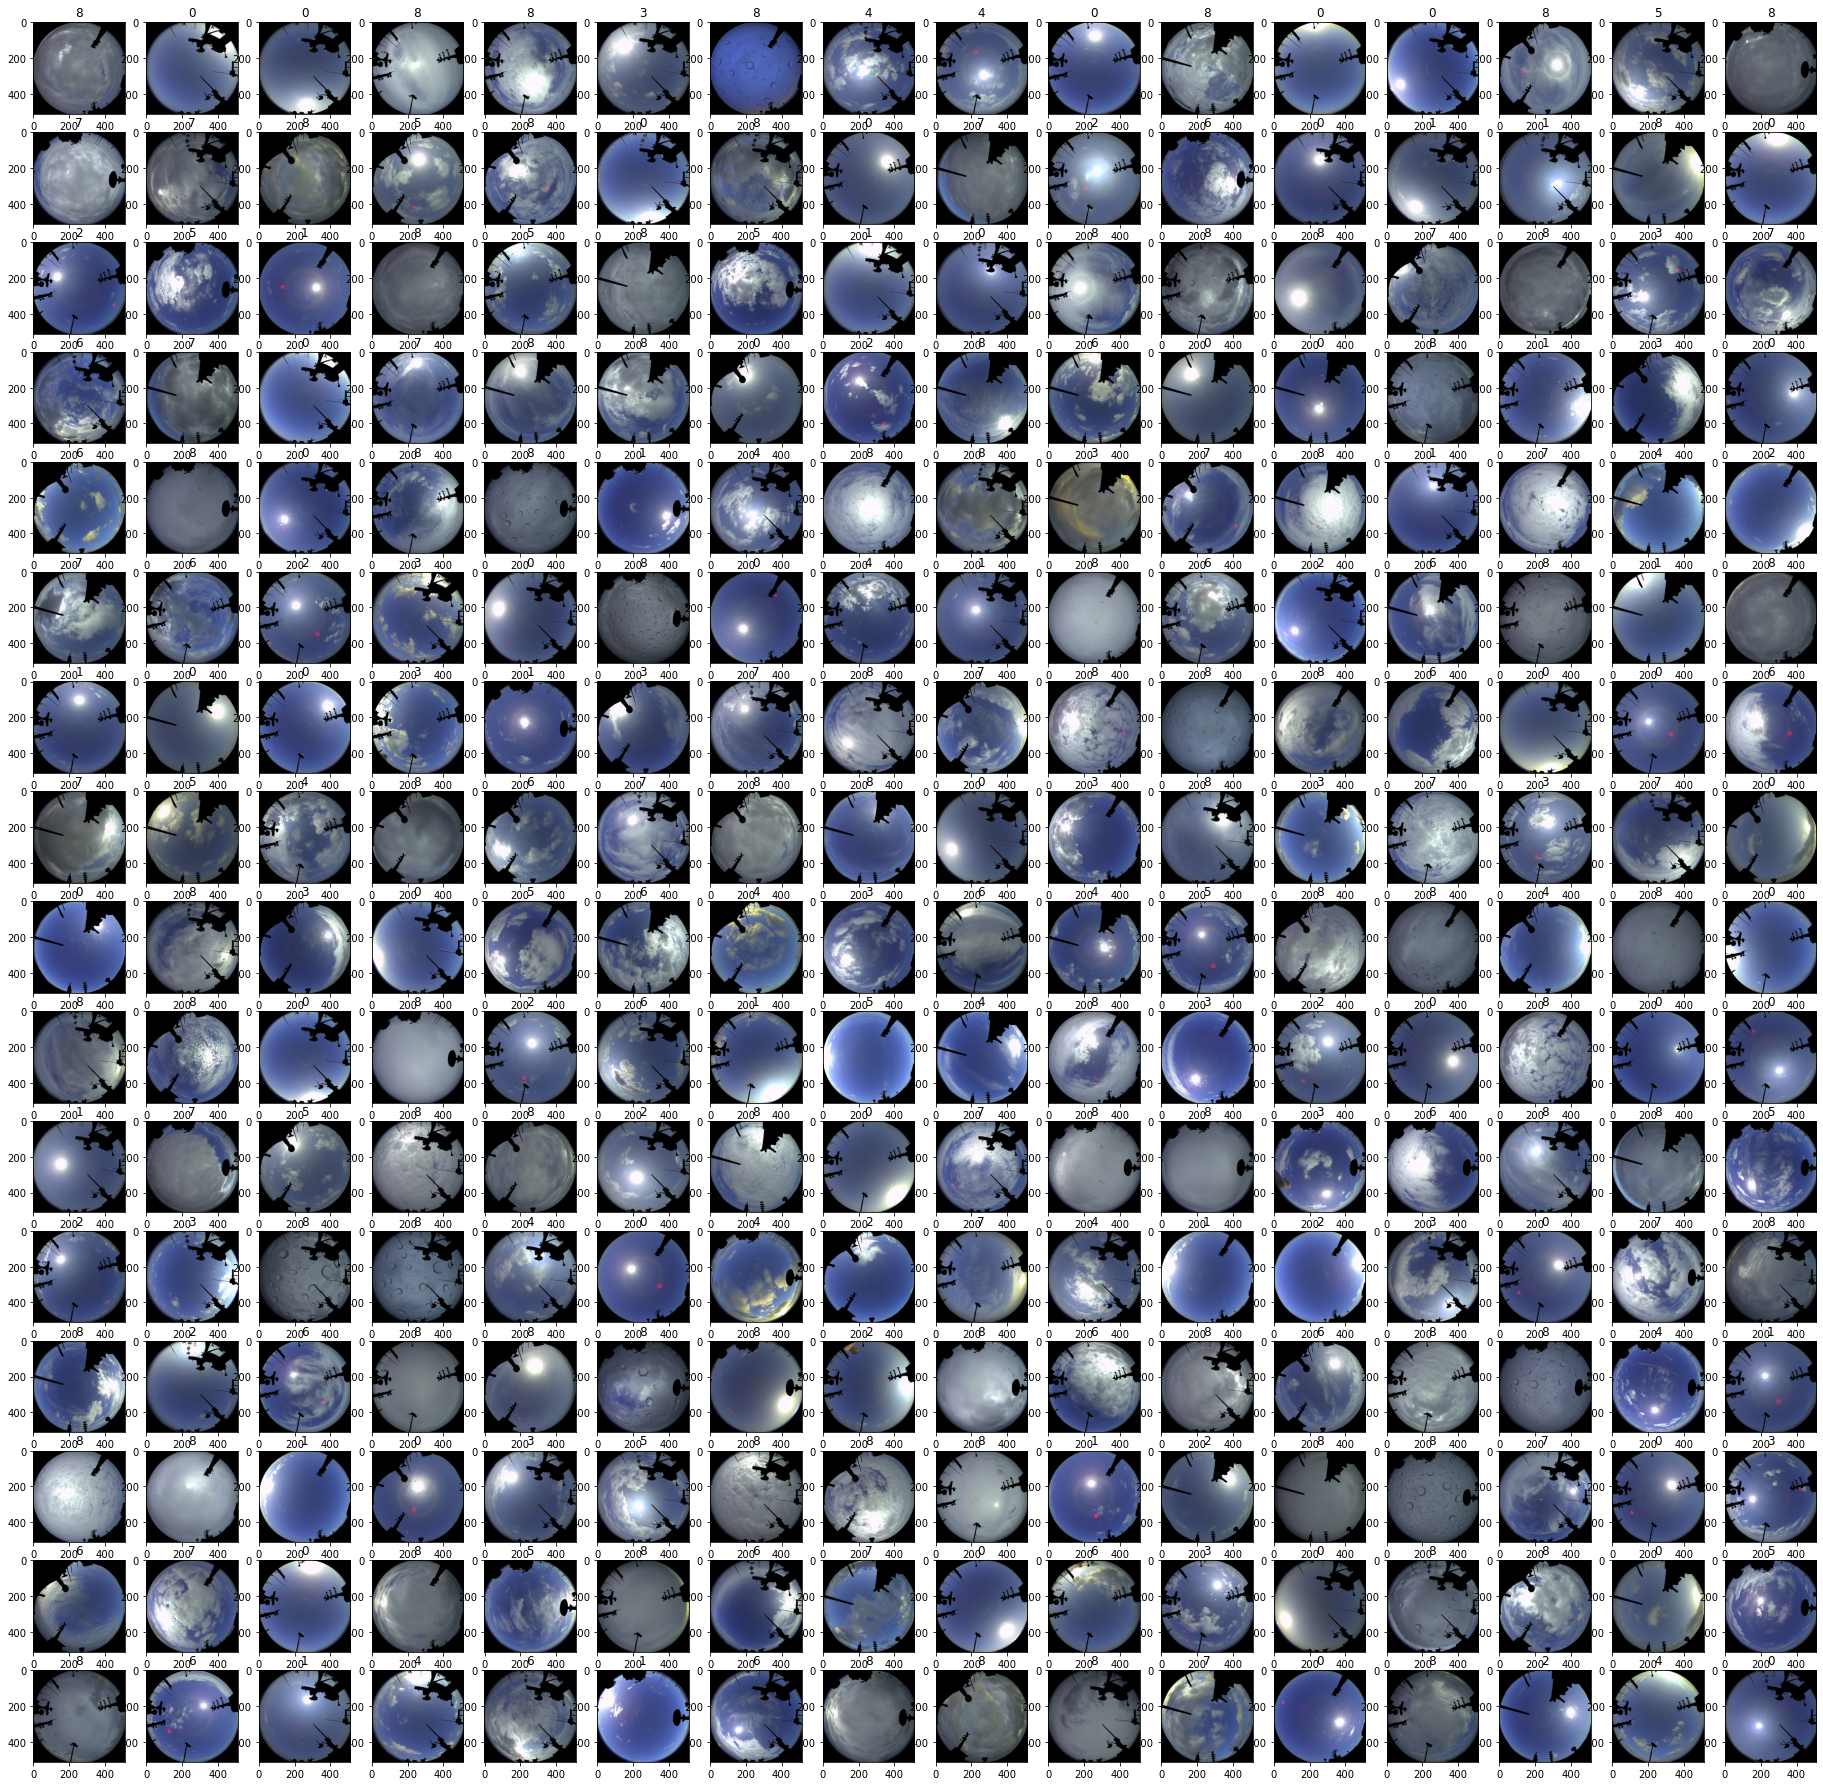

In [13]:
#  indices = np.random.randint(0, len(train_dataset), size=256)

#  fig, axes = plt.subplots(nrows=16, ncols=16, figsize=(32, 32))
#  for i, row in enumerate(axes):
#      for j, ax in enumerate(row):
#          sample_index = indices[i*16+j]
#          sample, label = train_dataset[sample_index]
#          ax.imshow(sample.cpu().numpy().transpose(1, 2, 0))
#          ax.set_title(label)

In [13]:

torch.cuda.empty_cache()


In [13]:
#print('./model/tensor'+str(1)+'.pt')
def train_model(model: torch.nn.Module, 
                train_dataset: torch.utils.data.Dataset,
                val_dataset: torch.utils.data.Dataset,
                loss_function: torch.nn.Module = torch.nn.CrossEntropyLoss(),
                optimizer_class: Type[torch.optim.Optimizer] = torch.optim,
                optimizer_params: Dict = {},
                initial_lr = 0.01,
                lr_scheduler_class: Any = torch.optim.lr_scheduler.ReduceLROnPlateau,
                lr_scheduler_params: Dict = {},
                batch_size = 8,
                max_epochs = 10,
                early_stopping_patience = 20):
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, **optimizer_params)
    lr_scheduler = lr_scheduler_class(optimizer, **lr_scheduler_params)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

    best_val_loss = None
    best_epoch = None
    ##cuda
    for epoch in range(0,max_epochs,1):
        
        print(f'Epoch {epoch}')
        train_single_epoch(model, optimizer, loss_function, train_loader)
        torch.save(model.state_dict(), './vgg16model/vgg'+str(epoch)+'.pt')
        with torch.no_grad():
            val_metrics = validate_single_epoch(model, loss_function, val_loader)
        print(f'Validation metrics: \n{val_metrics}')

        lr_scheduler.step(val_metrics['loss'])
        
        if best_val_loss is None or best_val_loss > val_metrics['loss']:
            print(f'Best model yet, saving')
            best_val_loss = val_metrics['loss']
            best_epoch = epoch
            torch.save(model, './best_model.pth')
            
        if epoch - best_epoch > early_stopping_patience:
            print('Early stopping triggered')
            return

In [14]:
def train_single_epoch(model: torch.nn.Module,
                       optimizer: torch.optim.Optimizer, 
                       loss_function: torch.nn.Module, 
                       data_loader: torch.utils.data.DataLoader):
    model.train()
    for batch_index, (data, target_perem) in enumerate(data_loader):
        data, target_perem = Variable(data), Variable(target_perem)
        data, target_perem = data.to(device), target_perem.to(device)######
        optimizer.zero_grad()
        model_out = model(data)
        loss = loss_function(model_out, target_perem)
        loss.backward()
        optimizer.step()
        if batch_index % len(data) == 0:
            train_loss_hist.append(loss)
            #print('Train Epoch:  [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #    batch_index * len(data), len(data_loader.dataset),
            #    100. * batch_index / len(data_loader), loss.item()))

In [15]:
test_loss_hist = []
torch.cuda.empty_cache()

In [16]:

def validate_single_epoch(model: torch.nn.Module,
                          loss_function: torch.nn.Module, 
                          data_loader: torch.utils.data.DataLoader):
    model.eval()
    loss = 0
    accuracy = 0
    for batch_index, (data, target_perem) in enumerate(data_loader):
        #print(batch_index)
        data, target_perem = data.to(device), target_perem.to(device)######
        #print(2)
        model_out = model(data)
        #print(3)
        loss_perem = loss_function(model_out, target_perem)
        #print(loss_perem)
        #test_loss_hist.append(loss_perem)
        #print(5)
        loss += loss_perem
        #print(6)
        #loss += loss_function(model_out, target_perem)
        pred = model_out.argmax(dim=1, keepdim=True)
        #print(7)
        #print(pred, target_perem.view_as(pred))
        accuracy += pred.eq(target_perem.view_as(pred)).sum().item()
        if batch_index % len(data) == 0:
            test_loss_hist.append(loss_perem)
            #print('Test Epoch:  [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(batch_index * len(data), len(data_loader.dataset),100. * batch_index / len(data_loader), loss_perem.item()))
        #print(8)
    loss = loss/len(data_loader)
    #print(9)
    test_loss_hist.append(loss)
    a = {'loss': loss.item(), 'accuracy': accuracy}
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(loss, accuracy, len(data_loader.dataset), 100. *accuracy / len(data_loader.dataset)))
    return a

In [18]:
train_model(model, 
            train_dataset=train_dataset, 
            val_dataset=val_dataset, 
            loss_function=torch.nn.CrossEntropyLoss(), 
            initial_lr=0.0001)

Epoch 0


KeyboardInterrupt: 

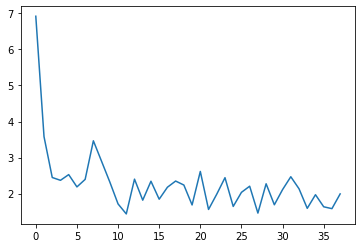

In [19]:
#torch.save(model.state_dict(), "./model/tensor.pt")
plt.plot(train_loss_hist)

In [61]:
with open('./test/index.pkl', 'rb') as f:
    test_data_index = pickle.load(f)

In [62]:
test_data_index[0]

{'jpg_filename': '74c59e4b-6039-4310-bdd8-269da54d16cc.jpg',
 'mask_fname': 'AI49/masks/mask-id2.png',
 'mission': 'AI49',
 'devID': 2,
 'observations_dt': datetime.datetime(2015, 6, 29, 22, 0)}

In [54]:
def pil_loader(path: str, index) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


# TODO: specify the return type
def accimage_loader(path: str, index) -> Any:
    import accimage
    try:
        return accimage.Image(path, index)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path, index)


def default_loader(path: str, index) -> Any:
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path, index)
    else:
        return pil_loader(path, index)

In [55]:
class TestFolder(Dataset):
    def __init__(self, 
            root: str,
            transform:Optional[Callable] = None,
            target_transform: Optional[Callable] = None):

        Samples = []
        for i in range(len(test_data_index)):
            Path = './test/'+test_data_index[i]['jpg_filename']
            Target = test_data_index[i]['jpg_filename']
            res = Path, Target
            Samples.append(res)

        self.samples = Samples
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        Sample = default_loader(path, index)
        mask = default_loader('./train/' + data_index[index]['mask_fname'])
        mask = mask.resize((512,512))
        
        if self.transform is not None:
            Sample = self.transform(Sample)
            mask = self.transform(mask)
        if self.target_transform is not None:
            target = self.target_transform(target)

        Sample = mask * Sample

        return Sample, target

In [56]:
test_dataset = TestFolder('./test/', transform=train_transforms)

In [57]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

In [59]:


def test(model):
    model.eval()
     
    for batch_index, (data, target_perem) in enumerate(test_loader):
        data = data.to(device)
        
        model_out = model(data)

        pred = model_out.argmax(dim=1, keepdim=True)
        for i in pred:
            print(target_perem[0],',',pred[0].item(),sep='',file = sample)
            
            #anslist.append(str.strip(target_perem[0]+','+str(pred[0].item() ) ) )

            #print(target_perem,pred,file = sample)
                


In [60]:
sample = open('ans2.csv', 'w').to(device)
print('jpg_filename,TCC',file = sample)
with torch.no_grad():
    test(model)
    
sample.close()

<ipython-input-46-e3f132127125>:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)
